# Eksploracja i preprocessing danych zbioru "Chess king rook"
Julia Kaznowska, Piotr Wilczyński <br>
Politechnika Warszawska, Wydział Matematyki i Nauk Informacyjnych, Wstęp do uczenia maszynowego

## Import niezbędnych bibliotek oraz zbioru danych

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
pd.options.mode.chained_assignment = None

# zbior danych
df = pd.read_csv("chess_king_rook_dataset.csv")

# wyświetlanie wizualizacji
%matplotlib inline

Wyświetlanie wizualizacji c.d..

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Opis zbioru

Zbiór "Chess king rook" zawiera dane dotyczące końcówek meczów szachowych, w których na szachownicy zostały trzy figury: biały król, czarny król i biała wieża.

Opis kolumn znajudje się w pliku "attributes_chess_king_rook.csv".

In [4]:
attr = pd.read_csv("attributes_chess_king_rook.csv")
with pd.option_context('display.max_colwidth', 400):
    display(attr)

,name,type,description
0,white_king_file,string,Column location on the chess board of the white king
1,white_king_rank,string,Row location on the chess board of the white king
2,white_rook_file,string,Column location on the chess board of the white rook
3,white_rook_rank,string,Row location on the chess board of the white rook
4,black_king_file,string,Column location on the chess board of the black king
5,black_king_rank,string,Row location on the chess board of the black king
6,result,string,"Predictor Class. optimal depth-of-win for White in 0 to 16 moves, otherwise drawn Values: {draw, zero, one, two, ..., sixteen}"


In [5]:
df.shape

(28056, 7)

Zbiór składa się z 28056 rekordów i 7 kolumn.

Zobaczmy kilka pierwszych rekordów w zbiorze.

In [6]:
df.head()

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result
0,a,1,b,3,c,2,draw
1,a,1,c,1,c,2,draw
2,a,1,c,1,d,1,draw
3,a,1,c,1,d,2,draw
4,a,1,c,2,c,1,draw


Według informacji znajdujących się na stronie, na których znajdował się dane, zbiór nie powinien mieć braków. Sprawdźmy to.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28056 entries, 0 to 28055
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   white_king_file  28056 non-null  object
 1   white_king_rank  28056 non-null  int64 
 2   white_rook_file  28056 non-null  object
 3   white_rook_rank  28056 non-null  int64 
 4   black_king_file  28056 non-null  object
 5   black_king_rank  28056 non-null  int64 
 6   result           28056 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.5+ MB


Zbiór nie ma braków danych.

Warto zauważyć, że mimo tego iż kolumy <i>white_king_rank</i>, <i>white_rook_rank</i> oraz <i>black_king_rank</i> są reprezentowane przez liczby to przyjmują one jedynie liczby całkowite od 1 do 8. Możemy traktować je jako zmienne kategoryczne. 

## Podział zbioru danych i wstępna eksploracja

In [8]:
y = np.array(df["result"])
X = df.drop(["result"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=123
)

In [9]:
X_train.head()

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank
23438,c,1,g,6,a,6
14397,c,2,d,5,g,7
3259,d,1,g,3,b,1
22413,b,2,d,7,g,5
8352,a,1,d,3,f,1


In [10]:
y_train

array(['fourteen', 'twelve', 'four', ..., 'thirteen', 'eleven', 'draw'],
      dtype=object)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(19639, 6)
(19639,)
(8417, 6)
(8417,)


In [12]:
df_train = X_train
X_train["result"] = y_train
df_test = X_test
X_test["result"] = y_test

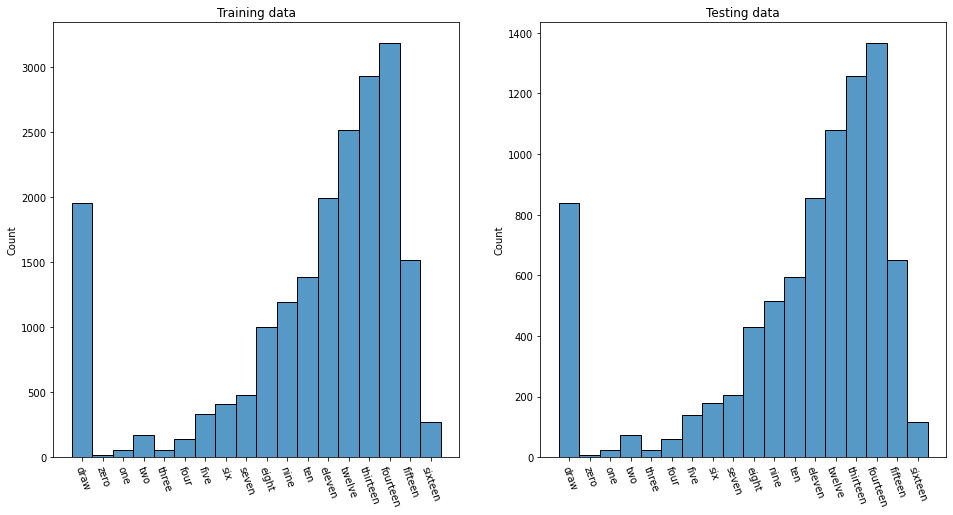

In [13]:
# set order
y_train = pd.Categorical(y_train, ["draw", "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen"])
y_test = pd.Categorical(y_test, ["draw", "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen"])

# plot
fig, axes = plt.subplots(1, 2, figsize = (16, 8))
sns.histplot(y_train, ax = axes[0])
sns.histplot(y_test, ax = axes[1])
plt.sca(axes[0])
plt.xticks(rotation = -70)
plt.title("Training data")
plt.sca(axes[1])
plt.xticks(rotation = -70)
plt.title("Testing data")
plt.show()

Rozkłady są takie same, zatem zbiór wydaje się być dobrze podzielony.

### Rozkład zmiennej <i>result</i>

Poza wyróżniającą się liczbą remisów, możemy zaobserwować rozkład lewostronnie skośny o dominancie "fourteen".

W dalszej części będziemy pracować na danych treningowych i sprawdzać wyniki na danych testowych.

In [14]:
df_train.head()

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result
23438,c,1,g,6,a,6,fourteen
14397,c,2,d,5,g,7,twelve
3259,d,1,g,3,b,1,four
22413,b,2,d,7,g,5,fourteen
8352,a,1,d,3,f,1,ten


### Pozycje białego króla

Przeanalizujmy częstość występowania danych pól dla każdej z figur.

In [15]:
df_white_king = df_train[["white_king_file", 'white_king_rank', 'result']]
df_white_king = df_train.pivot_table(index = "white_king_rank",\
                                          columns ='white_king_file',\
                                          values = "result",\
                                          aggfunc='count',\
                                          fill_value = '0')
df_white_king

white_king_file,a,b,c,d
white_king_rank,,,,
1,1319,2508,2522,2548.0
2,0,1210,2331,2405.0
3,0,0,1220,2363.0
4,0,0,0,1213.0


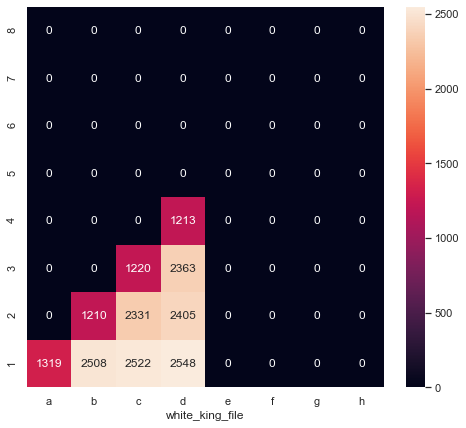

In [16]:
df_white_king[["e","f","g","h"]] = [0,0,0,0]
df_white_king = pd.concat([df_white_king, df_white_king], axis=0, ignore_index=True)
df_white_king.index +=1
df_white_king.iloc[4:8,0:4] = np.zeros([4,4])
df_white_king = df_white_king.astype(int)

sns.set(rc = {'figure.figsize':(8,7)})
g = sns.heatmap(df_white_king, annot=True, fmt="d")
g.invert_yaxis()

Wnioski:
- Biały król występuje tylko na trójkącie prostokątnym (a1, d1, d4)
- Występuje około dwa razy rzadziej na przeciwprostokątnej

#### Sprawdzenie dla danych testowych

In [17]:
df_white_king_test = df_test[["white_king_file", 'white_king_rank', 'result']]
df_white_king_test = df_test.pivot_table(index = "white_king_rank",\
                                          columns ='white_king_file',\
                                          values = "result",\
                                          aggfunc='count',\
                                          fill_value = '0')
df_white_king_test

white_king_file,a,b,c,d
white_king_rank,,,,
1,559,1088,1074,1048.0
2,0,510,1079,1005.0
3,0,0,500,1047.0
4,0,0,0,507.0


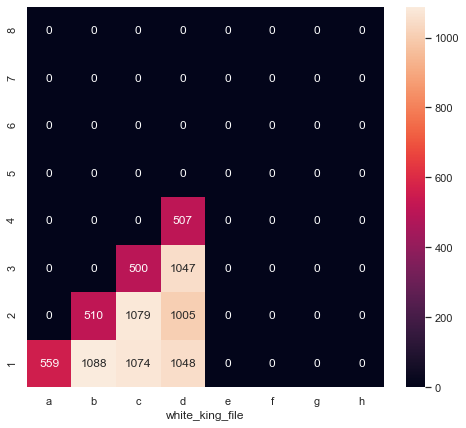

In [18]:
df_white_king_test[["e","f","g","h"]] = [0,0,0,0]
df_white_king_test = pd.concat([df_white_king_test, df_white_king_test], axis=0, ignore_index=True)
df_white_king_test.index +=1
df_white_king_test.iloc[4:8,0:4] = np.zeros([4,4])
df_white_king_test = df_white_king_test.astype(int)

sns.set(rc = {'figure.figsize':(8,7)})
g = sns.heatmap(df_white_king_test, annot=True, fmt="d")
g.invert_yaxis()

Wnioski się zgadzają (a1 występuje trochę częściej ale wydaje się to być statystycznie nieistotne). Biały król występuje tylko na trójkącie prostokątnym (a1, d1, d4) oraz występuje około dwa razy rzadziej na przeciwprostokątnej.

### Pozycje białej wieży

In [19]:
df_white_rook = df_train[["white_rook_file", 'white_rook_rank', 'result']]
df_white_rook = df_train.pivot_table(index = "white_rook_rank",\
                                          columns ='white_rook_file',\
                                          values = "result",\
                                          aggfunc='count',\
                                          fill_value = '0')
df_white_rook

white_rook_file,a,b,c,d,e,f,g,h
white_rook_rank,,,,,,,,
1,283,297,278,264,319,317,313,295
2,296,295,278,285,310,313,339,314
3,306,330,301,273,329,313,327,335
4,308,311,310,269,314,328,318,304
5,307,327,282,306,311,326,323,293
6,276,314,308,318,296,311,322,300
7,304,311,299,306,305,296,320,304
8,308,317,312,300,319,316,309,321


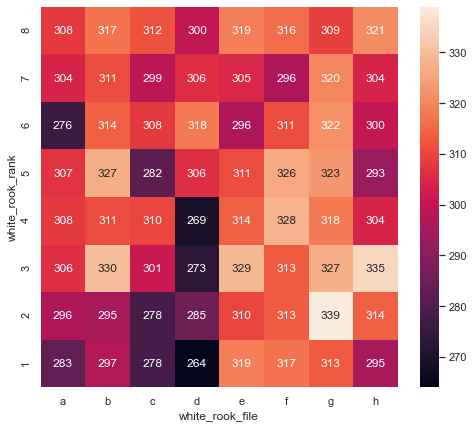

In [20]:
df_white_rook = df_white_rook.astype(int)
sns.set(rc = {'figure.figsize':(8,7)})
g = sns.heatmap(df_white_rook, annot=True, fmt="d")
g.invert_yaxis()
plt.show()

Wnioski:
- Biała wieża występuje mniej więcej z równą częstością na każdym polu. Rozstęp wynosi 339 - 264 = 75

#### Sprawdzenie dla danych testowych

In [21]:
df_white_rook_test = df_test[["white_rook_file", 'white_rook_rank', 'result']]
df_white_rook_test = df_test.pivot_table(index = "white_rook_rank",\
                                          columns ='white_rook_file',\
                                          values = "result",\
                                          aggfunc='count',\
                                          fill_value = '0')
df_white_rook_test

white_rook_file,a,b,c,d,e,f,g,h
white_rook_rank,,,,,,,,
1,139,102,122,134,135,135,139,157
2,140,133,127,118,145,139,113,138
3,129,106,127,129,126,139,125,117
4,127,124,126,156,140,124,134,148
5,128,108,153,129,142,126,129,159
6,159,121,127,117,139,141,130,152
7,131,124,136,129,130,139,132,148
8,127,118,123,135,116,119,126,131


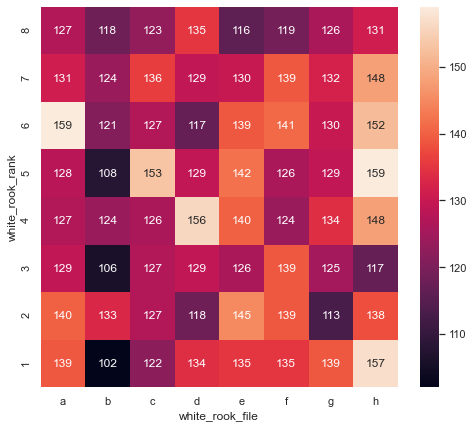

In [22]:
df_white_rook_test = df_white_rook_test.astype(int)
sns.set(rc = {'figure.figsize':(8,7)})
g = sns.heatmap(df_white_rook_test, annot=True, fmt="d")
g.invert_yaxis()

Wieża występuję na każdym polu z mniej więcej tą samą częstością. Wniosek wydaje się być prawdziwy.

### Pozycje czarnego króla

In [23]:
df_black_king = df_train[["black_king_file", 'black_king_rank', 'result']]
df_black_king = df_train.pivot_table(index = "black_king_rank",\
                                          columns ='black_king_file',\
                                          values = "result",\
                                          aggfunc='count',\
                                          fill_value = '0')
df_black_king

black_king_file,a,b,c,d,e,f,g,h
black_king_rank,,,,,,,,
1,263,219,180,257,350,420,444,452
2,205,157,86,163,311,440,423,427
3,257,215,152,194,300,437,439,437
4,256,267,213,262,346,443,437,439
5,258,264,270,265,328,446,445,452
6,263,275,253,258,243,358,440,443
7,264,274,265,235,253,254,340,446
8,258,248,258,254,251,262,271,354


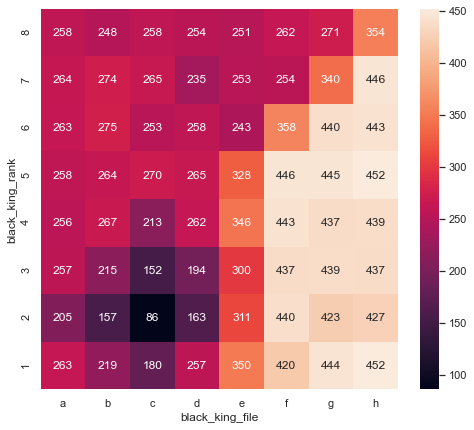

In [24]:
df_black_king = df_black_king.astype(int)
sns.set(rc = {'figure.figsize':(8,7)})
g = sns.heatmap(df_black_king, annot=True, fmt="d")
g.invert_yaxis()

Wnioski:
- czarny król występuje częściej po prawej stronie (w kolumnach e-h)
- czarny król występuje wyjątkowo rzadko na polu c2

#### Sprawdzenie dla danych testowych

In [25]:
df_black_king_test = df_test[["black_king_file", 'black_king_rank', 'result']]
df_black_king_test = df_test.pivot_table(index = "black_king_rank",\
                                          columns ='black_king_file',\
                                          values = "result",\
                                          aggfunc='count',\
                                          fill_value = '0')
df_black_king_test

black_king_file,a,b,c,d,e,f,g,h
black_king_rank,,,,,,,,
1,115,91,68,115,146,200,176,168
2,105,63,38,85,123,180,197,193
3,115,95,68,116,134,183,181,183
4,116,105,97,116,150,177,183,181
5,114,108,102,107,146,174,175,168
6,109,97,119,114,129,150,180,177
7,108,98,107,137,119,118,168,174
8,114,124,114,118,121,110,101,154


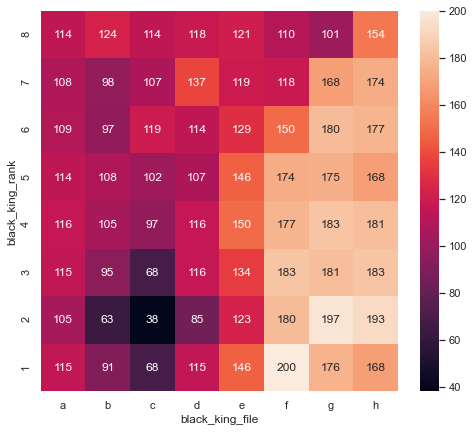

In [26]:
df_black_king_test = df_black_king_test.astype(int)
sns.set(rc = {'figure.figsize':(8,7)})
g = sns.heatmap(df_black_king_test, annot=True, fmt="d")
g.invert_yaxis()

Czarny król występuje zdecydowanie częściej po prawej stronie. Dodatkowo występuje wyjątkowo rzadko na polu c2. Wnioski wydają się być prawdziwe.

## Preprocessing danych

### Dane objaśniające treningowe

In [27]:
df_train = df_train.reset_index(drop = True)
df_train

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result
0,c,1,g,6,a,6,fourteen
1,c,2,d,5,g,7,twelve
2,d,1,g,3,b,1,four
3,b,2,d,7,g,5,fourteen
4,a,1,d,3,f,1,ten
...,...,...,...,...,...,...,...
19634,c,2,c,4,d,4,draw
19635,b,1,b,7,b,6,draw
19636,d,2,e,8,c,5,thirteen
19637,c,3,a,8,h,4,eleven


In [28]:
def get_edge_dist(A, B):
    file_to_number = A.apply(lambda x: ord(x) - 96)
    return np.minimum(np.minimum(file_to_number.to_numpy(), B.to_numpy()),\
                      np.minimum(9 - file_to_number.to_numpy(),9 - B.to_numpy()))

In [29]:
white_king_edge_dist = get_edge_dist(df_train['white_king_file'], df_train['white_king_rank'])
white_rook_edge_dist = get_edge_dist(df_train['white_rook_file'], df_train['white_rook_rank'])
black_king_edge_dist = get_edge_dist(df_train['black_king_file'], df_train['black_king_rank'])

In [30]:
def is_in_corner(A, B):
    res = ((A == 'a') & (B == 1)) | ((A == 'a') & ((B == 8))) | ((A == 'h') & (B == 1)) | ((A == 'h') & (B == 8))
    return np.where(res, 1, 0)

In [31]:
white_king_in_corner = is_in_corner(df_train['white_king_file'], df_train['white_king_rank'])
white_rook_in_corner = is_in_corner(df_train['white_rook_file'], df_train['white_rook_rank'])
black_king_in_corner = is_in_corner(df_train['black_king_file'], df_train['black_king_rank'])

In [32]:
def get_distance_x(A, B):
    file_to_number_A = A.apply(lambda x: ord(x) - 96)
    file_to_number_B = B.apply(lambda x: ord(x) - 96)
    return abs(file_to_number_A - file_to_number_B)

In [33]:
def get_distance_y(A, B):
    return abs(A - B)

In [34]:
wking_wrook_dist_x = get_distance_x(df_train['white_king_file'], df_train['white_rook_file'])
wking_wrook_dist_y = get_distance_y(df_train['white_king_rank'], df_train['white_rook_rank'])
wking_bking_dist_x = get_distance_x(df_train['white_king_file'], df_train['black_king_file'])
wking_bking_dist_y = get_distance_y(df_train['white_king_rank'], df_train['black_king_rank'])
wrook_bking_dist_x = get_distance_x(df_train['white_rook_file'], df_train['black_king_file'])
wrook_bking_dist_y = get_distance_y(df_train['white_rook_rank'], df_train['black_king_rank'])

In [35]:
processed_train_frame = {"white_king_edge_dist" : white_king_edge_dist, "white_rook_edge_dist" : white_rook_edge_dist,\
                  "black_king_edge_dist" : black_king_edge_dist, "white_king_in_corner" : white_king_in_corner,\
                  "white_rook_in_corner" : white_rook_in_corner, "black_king_in_corner" : black_king_in_corner,\
                  "wking_wrook_dist_x" : wking_wrook_dist_x, "wking_wrook_dist_y" : wking_wrook_dist_y,\
                  "wking_bking_dist_x" : wking_bking_dist_x, "wking_bking_dist_y" : wking_bking_dist_y,\
                  "wrook_bking_dist_x" : wrook_bking_dist_x, "wrook_bking_dist_y" : wrook_bking_dist_y}

In [36]:
df_train_processed = pd.DataFrame(processed_train_frame)
df_train_processed

,white_king_edge_dist,white_rook_edge_dist,black_king_edge_dist,white_king_in_corner,white_rook_in_corner,black_king_in_corner,wking_wrook_dist_x,wking_wrook_dist_y,wking_bking_dist_x,wking_bking_dist_y,wrook_bking_dist_x,wrook_bking_dist_y
0,1,2,1,0,0,0,4,5,2,5,6,0
1,2,4,2,0,0,0,1,3,4,5,3,2
2,1,2,1,0,0,0,3,2,2,0,5,2
3,2,2,2,0,0,0,2,5,5,3,3,2
4,1,3,1,1,0,0,3,2,5,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
19634,2,3,4,0,0,0,0,2,1,2,1,0
19635,1,2,2,0,0,0,0,6,0,5,0,1
19636,2,1,3,0,0,0,1,6,1,3,2,3
19637,3,1,1,0,1,0,2,5,5,1,7,4


### Dane objaśniające testowe

In [37]:
df_test = df_test.reset_index(drop = True)
df_test

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result
0,d,1,c,5,e,3,fourteen
1,d,1,g,1,a,4,thirteen
2,c,2,a,7,h,5,thirteen
3,b,1,f,5,f,2,fifteen
4,d,1,h,6,a,4,fourteen
...,...,...,...,...,...,...,...
8412,c,1,g,2,c,6,fifteen
8413,d,1,h,6,a,3,twelve
8414,b,1,c,8,f,3,fourteen
8415,d,4,h,7,h,1,eight


In [38]:
white_king_edge_dist = get_edge_dist(df_test['white_king_file'], df_test['white_king_rank'])
white_rook_edge_dist = get_edge_dist(df_test['white_rook_file'], df_test['white_rook_rank'])
black_king_edge_dist = get_edge_dist(df_test['black_king_file'], df_test['black_king_rank'])

In [39]:
white_king_in_corner = is_in_corner(df_test['white_king_file'], df_test['white_king_rank'])
white_rook_in_corner = is_in_corner(df_test['white_rook_file'], df_test['white_rook_rank'])
black_king_in_corner = is_in_corner(df_test['black_king_file'], df_test['black_king_rank'])

In [40]:
wking_wrook_dist_x = get_distance_x(df_test['white_king_file'], df_test['white_rook_file'])
wking_wrook_dist_y = get_distance_y(df_test['white_king_rank'], df_test['white_rook_rank'])
wking_bking_dist_x = get_distance_x(df_test['white_king_file'], df_test['black_king_file'])
wking_bking_dist_y = get_distance_y(df_test['white_king_rank'], df_test['black_king_rank'])
wrook_bking_dist_x = get_distance_x(df_test['white_rook_file'], df_test['black_king_file'])
wrook_bking_dist_y = get_distance_y(df_test['white_rook_rank'], df_test['black_king_rank'])

In [41]:
processed_test_frame = {"white_king_edge_dist" : white_king_edge_dist, "white_rook_edge_dist" : white_rook_edge_dist,\
                  "black_king_edge_dist" : black_king_edge_dist, "white_king_in_corner" : white_king_in_corner,\
                  "white_rook_in_corner" : white_rook_in_corner, "black_king_in_corner" : black_king_in_corner,\
                  "wking_wrook_dist_x" : wking_wrook_dist_x, "wking_wrook_dist_y" : wking_wrook_dist_y,\
                  "wking_bking_dist_x" : wking_bking_dist_x, "wking_bking_dist_y" : wking_bking_dist_y,\
                  "wrook_bking_dist_x" : wrook_bking_dist_x, "wrook_bking_dist_y" : wrook_bking_dist_y}

In [42]:
df_test_processed = pd.DataFrame(processed_test_frame)
df_test_processed

,white_king_edge_dist,white_rook_edge_dist,black_king_edge_dist,white_king_in_corner,white_rook_in_corner,black_king_in_corner,wking_wrook_dist_x,wking_wrook_dist_y,wking_bking_dist_x,wking_bking_dist_y,wrook_bking_dist_x,wrook_bking_dist_y
0,1,3,3,0,0,0,1,4,1,2,2,2
1,1,1,1,0,0,0,3,0,3,3,6,3
2,2,1,1,0,0,0,2,5,5,3,7,2
3,1,3,2,0,0,0,4,4,4,1,0,3
4,1,1,1,0,0,0,4,5,3,3,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...
8412,1,2,3,0,0,0,4,1,0,5,4,4
8413,1,1,1,0,0,0,4,5,3,2,7,3
8414,1,1,3,0,0,0,1,7,4,2,3,5
8415,4,1,1,0,0,1,4,3,4,3,0,6


### Dane objaśniane

Zmieniamy dane przedstawione słownie w dane liczbowe (draw = -1)

In [43]:
def result_processing(x):
    if x["result"] == "draw":  return -1
    elif x["result"] == "zero": return 0
    elif x["result"] == "one": return 1
    elif x["result"] == "two": return 2
    elif x["result"] == "three": return 3
    elif x["result"] == "four": return 4
    elif x["result"] == "five": return 5
    elif x["result"] == "six": return 6
    elif x["result"] == "seven": return 7
    elif x["result"] == "eight": return 8
    elif x["result"] == "nine": return 9
    elif x["result"] == "ten": return 10
    elif x["result"] == "eleven": return 11
    elif x["result"] == "twelve": return 12
    elif x["result"] == "thirteen": return 13
    elif x["result"] == "fourteen": return 14
    elif x["result"] == "fifteen": return 15
    else: return 16

In [44]:
y_train_processed = df_train.apply(lambda row: result_processing(row), axis=1)
y_test_processed = df_test.apply(lambda row: result_processing(row), axis=1)
df_train_processed["result"] = y_train_processed
df_test_processed["result"] = y_test_processed

## Analiza jednoczynnikowa

In [45]:
columns = df_train_processed.columns.values
columns = np.delete(columns, [12])

### Dane treningowe

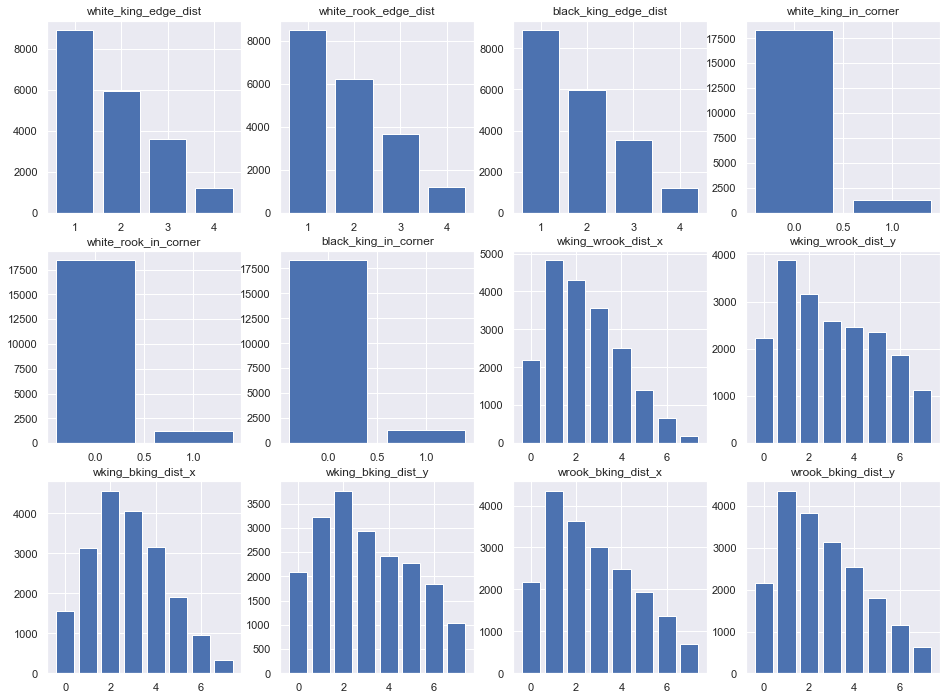

In [46]:
fig, axes = plt.subplots(3, 4, figsize = (16, 12))
for i in range(len(df_train_processed.columns) - 1):
    cntr = Counter(df_train_processed[df_train_processed.columns.values[i]])
    axes[i//4][i%4].set_title(df_train_processed.columns[i])
    axes[i//4][i%4].bar(cntr.keys(), cntr.values())

- im większa odległość figur od krawędzi, tym mniej zarejestrowanych przypadków
- bardzo mało przypadków dla figur w rogach
- im mniejsza odległość białej wieży od białego króla (w dowolnej osi), tym więcej przypadków (nie licząc odległości 0)
- najwięcej zarejestowanych przypdaków dla odległości 2 między królami; im większa odległość, tym liczba przypadków spada (nie licząc 0 i 1)
- im mniejsza odległość białej wieży od czarnego króla (w dowolnej osi), tym więcej przypadków (nie licząc odległości 0)

### Dane testowe

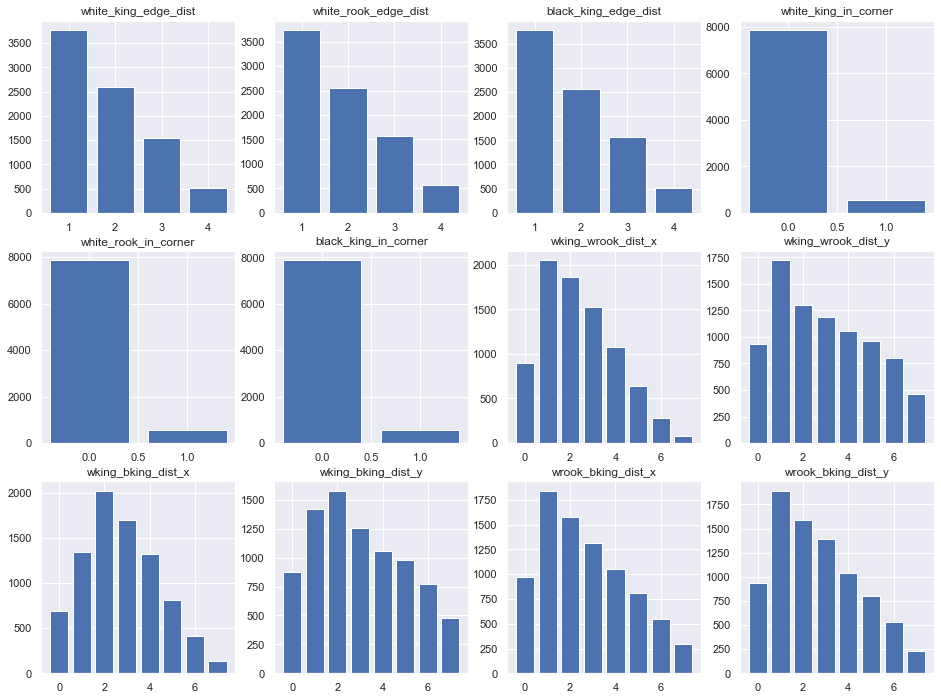

In [47]:
fig, axes = plt.subplots(3, 4, figsize = (16, 12))
for i in range(len(df_test_processed.columns) - 1):
    cntr = Counter(df_test_processed[df_test_processed.columns.values[i]])
    axes[i//4][i%4].set_title(df_test_processed.columns[i])
    axes[i//4][i%4].bar(cntr.keys(), cntr.values())

Można wyciągnąć identyczne wnioski jak w przypadku danych treningowych.

## Analiza korelacji

In [48]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = df_train_processed.corr()
corr.style.background_gradient(cmap='coolwarm')

,white_king_edge_dist,white_rook_edge_dist,black_king_edge_dist,white_king_in_corner,white_rook_in_corner,black_king_in_corner,wking_wrook_dist_x,wking_wrook_dist_y,wking_bking_dist_x,wking_bking_dist_y,wrook_bking_dist_x,wrook_bking_dist_y,result
white_king_edge_dist,1.000000,-0.022182,-0.086934,-0.246663,0.006054,0.017522,-0.109547,-0.258825,-0.075872,-0.285180,0.013032,0.025864,-0.247453
white_rook_edge_dist,-0.022182,1.000000,-0.008629,0.006292,-0.243223,0.007591,-0.301588,-0.100178,0.009377,0.009853,-0.176181,-0.202181,-0.091966
black_king_edge_dist,-0.086934,-0.008629,1.000000,0.018472,0.001695,-0.247608,0.027963,0.015162,-0.344956,-0.067790,-0.199151,-0.193306,0.223405
white_king_in_corner,-0.246663,0.006292,0.018472,1.000000,-0.014454,-0.016310,0.217397,0.060488,0.370869,-0.089974,-0.020335,0.004564,0.109385
white_rook_in_corner,0.006054,-0.243223,0.001695,-0.014454,1.000000,-0.009761,0.191790,0.079948,-0.004761,0.003449,0.105852,0.132086,0.059762
black_king_in_corner,0.017522,0.007591,-0.247608,-0.016310,-0.009761,1.000000,-0.004713,-0.008014,0.188579,0.053924,0.122440,0.139669,-0.146416
wking_wrook_dist_x,-0.109547,-0.301588,0.027963,0.217397,0.191790,-0.004713,1.000000,-0.005778,0.109604,-0.005215,-0.052233,0.002991,0.018839
wking_wrook_dist_y,-0.258825,-0.100178,0.015162,0.060488,0.079948,-0.008014,-0.005778,1.000000,0.019141,0.053082,-0.001248,0.032975,0.068804
wking_bking_dist_x,-0.075872,0.009377,-0.344956,0.370869,-0.004761,0.188579,0.109604,0.019141,1.000000,-0.171258,0.148764,0.010622,0.005054
wking_bking_dist_y,-0.285180,0.009853,-0.067790,-0.089974,0.003449,0.053924,-0.005215,0.053082,-0.171258,1.000000,-0.013168,0.040919,0.191517


In [49]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = df_test_processed.corr()
corr.style.background_gradient(cmap='coolwarm')

,white_king_edge_dist,white_rook_edge_dist,black_king_edge_dist,white_king_in_corner,white_rook_in_corner,black_king_in_corner,wking_wrook_dist_x,wking_wrook_dist_y,wking_bking_dist_x,wking_bking_dist_y,wrook_bking_dist_x,wrook_bking_dist_y,result
white_king_edge_dist,1.000000,0.005164,-0.114253,-0.247496,0.003379,0.028143,-0.116956,-0.262344,-0.072560,-0.287169,0.022878,0.035824,-0.255087
white_rook_edge_dist,0.005164,1.000000,-0.025911,0.003621,-0.247731,0.000595,-0.329227,-0.097907,0.004489,-0.001249,-0.180718,-0.192316,-0.109237
black_king_edge_dist,-0.114253,-0.025911,1.000000,0.025787,0.013146,-0.245255,0.034665,0.021578,-0.330470,-0.064291,-0.187612,-0.168847,0.245647
white_king_in_corner,-0.247496,0.003621,0.025787,1.000000,-0.018843,-0.018507,0.202774,0.059311,0.366526,-0.087546,-0.017042,-0.001695,0.112382
white_rook_in_corner,0.003379,-0.247731,0.013146,-0.018843,1.000000,-0.029573,0.191889,0.047485,-0.017677,-0.005517,0.122834,0.130377,0.064828
black_king_in_corner,0.028143,0.000595,-0.245255,-0.018507,-0.029573,1.000000,0.002982,-0.026656,0.191654,0.071621,0.088231,0.132749,-0.149908
wking_wrook_dist_x,-0.116956,-0.329227,0.034665,0.202774,0.191889,0.002982,1.000000,0.007147,0.113961,0.002458,-0.038065,0.013263,0.034889
wking_wrook_dist_y,-0.262344,-0.097907,0.021578,0.059311,0.047485,-0.026656,0.007147,1.000000,0.006273,0.066870,0.002937,0.029084,0.086089
wking_bking_dist_x,-0.072560,0.004489,-0.330470,0.366526,-0.017677,0.191654,0.113961,0.006273,1.000000,-0.170989,0.141661,0.003537,0.003593
wking_bking_dist_y,-0.287169,-0.001249,-0.064291,-0.087546,-0.005517,0.071621,0.002458,0.066870,-0.170989,1.000000,-0.022252,0.038404,0.201383


Zarówno dla danych treningowych jak i testowych możemy zauważyć brak silnych korelacji pomiędzy zmiennymi. Najwyższą korelację ma położenie króla w rogu i odległość między królami.

## Analiza wieloczynnikowa

### Dane treningowe

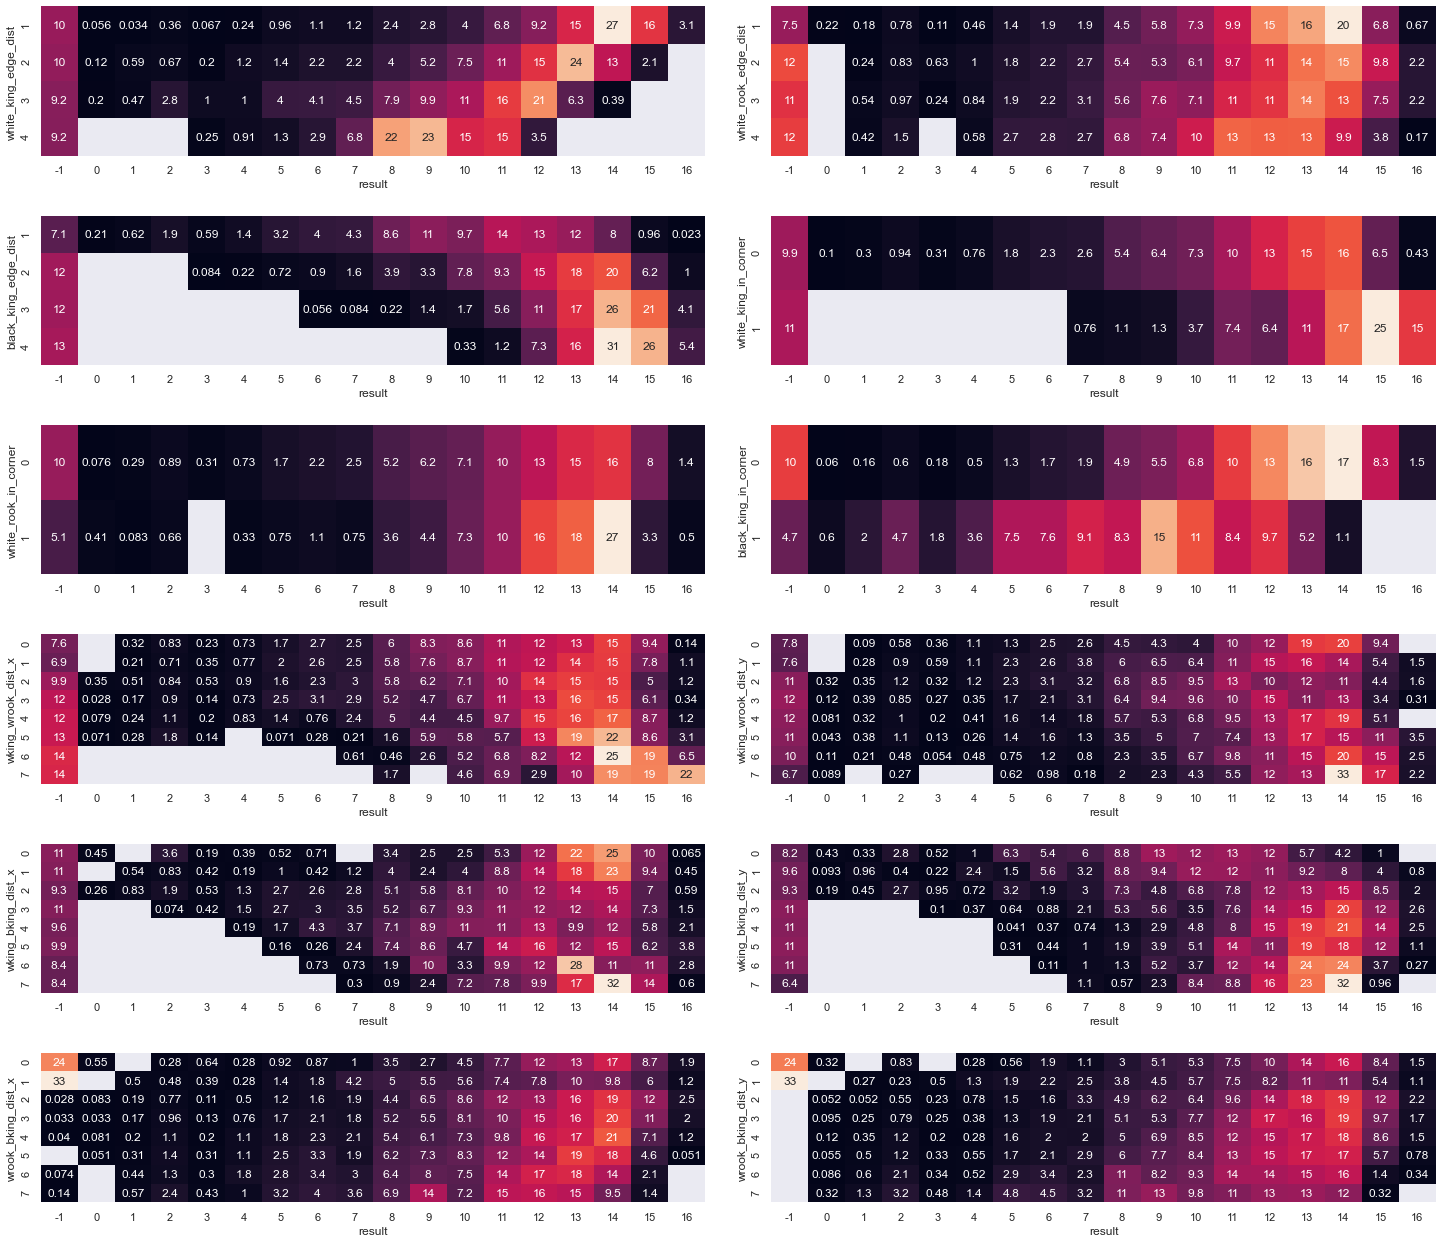

In [50]:
i = 0
fig, axes = plt.subplots(6, 2, figsize = (25, 22))
plt.subplots_adjust(wspace = 0.1, hspace = 0.4)
for col in columns:
    dfprep = df_train_processed.groupby(by = [col]).size().reset_index(name='count_all')
    dfprep2 = df_train_processed.groupby(by = [col, 'result']).size().reset_index(name='count')
    dfprep2 = pd.merge(dfprep, dfprep2, how = "left", on=col)
    dfprep2["percentage"] = dfprep2["count"]/dfprep2["count_all"]*100
    dfprep2 = dfprep2.pivot(col, "result", "percentage")
    sns.heatmap(dfprep2, annot=True, fmt = '.2g',\
                cbar_kws={'orientation': 'horizontal'}, ax = axes[i//2][i%2], cbar = False)
    i += 1
plt.show()

### Wnioski:

- Im dalej biały król jest od brzegu, tym ma większe szanse na wygraną w mniejszej liczbie ruchów (odległość 1 max prawdopodobieństwo w 14 ruchach, odległość 4 max prawdopodobieństwo w 9 ruchach)


- jedynie dla białej wieży w odległości 1 od brzegu jest zauważalna różnica między zwycięstwem w określonej liczbie ruchów a remisem (20% na wygraną w 14 ruchach do 7.5% na remis). Wieża zawsze matuje będąc przy krawędzi.
- najbardziej prawdopodobna wygrana w 11-14 ruchach


- im bardziej oddalony od brzegu czarny król, tym statystycznie potrzeba więcej ruchów do zwycięstwa (9-13 ruchów dla oddalenia 1, 13-15 dla oddalenia 4)


- jeśli biały król jest w rogu, statystycznie potrzeba więcej ruchów do wygranej


- niezależnie od pozycji białej wieży (w rogu bądź nie) największe prawdopodobieństwo jest na wygraną w 12-14 ruchach
- dla wieży w rogu jest mniejsze prawdopodobieństwo na remis (o 5 pkt.proc.)


- gdy czarny król nie jest w rogu, szanse na remis są większe (o ok. 5 pkt.proc)
- jeśli jednak jest w rogu, to wygrywa się statystycznie w mniejszej liczbie ruchów (największe prawdopodobieństwo dla 9 ruchów, natomiast dla 12-14, gdy nie jest w rogu)


- im większa różnica w odległości białej wieży od białego króla (w osi x), tym większa szansa na remis (oprócz odległości 1, gdzie ta szansa jest najmniejsza)
- dla odległości 0-5 podobne szanse na wygraną w podobnej liczbie ruchów (pik w 12-14), dla większych odległości pik przesuwa się w stronę większej liczby ruchów


- dla różnic odległości w osi y (biała wieża - biały król), skrajne odległości wymagają statystycznie więcej ruchów (?)
- aż w 1/3 rozgrywek wieża w odległości 7 dawała wygraną w 14 ruchach


- dla różnic odległości między królami w osi x występuje większe skoncentrowanie wartości dla skrajnych odległości (pik dla 13-14 ruchów) (?)
- wartości środkowe procentowo rozłożone "równiej", mniejsza liczba ruchów zbliża się prawdopobieństwem do wartości w piku (?)


- dla różnic odległości między królami w osi x występuje większe skoncentrowanie wartości dla większych odległości(?)


- dla różnic odległości między królami w osi y dla odległości 0 i 1 pik występuje w niższych wartościach (10-12), dla większych utrzymuje się około 13-14


- biała wieża w odległości 0 od czarnego króla (dla dowolnej z osi) daje wysokie prawdopodobieństwo na remis - aż 24%, natomiast w odległości 1 jest ono jeszcze większe - aż 33%
- w innych przypadkach remis praktycznie nie wystepuje
- poza tym podobny rozkład na wygrane dla wszystkich odległości - pik w 12-14 ruchach

### Dane testowe

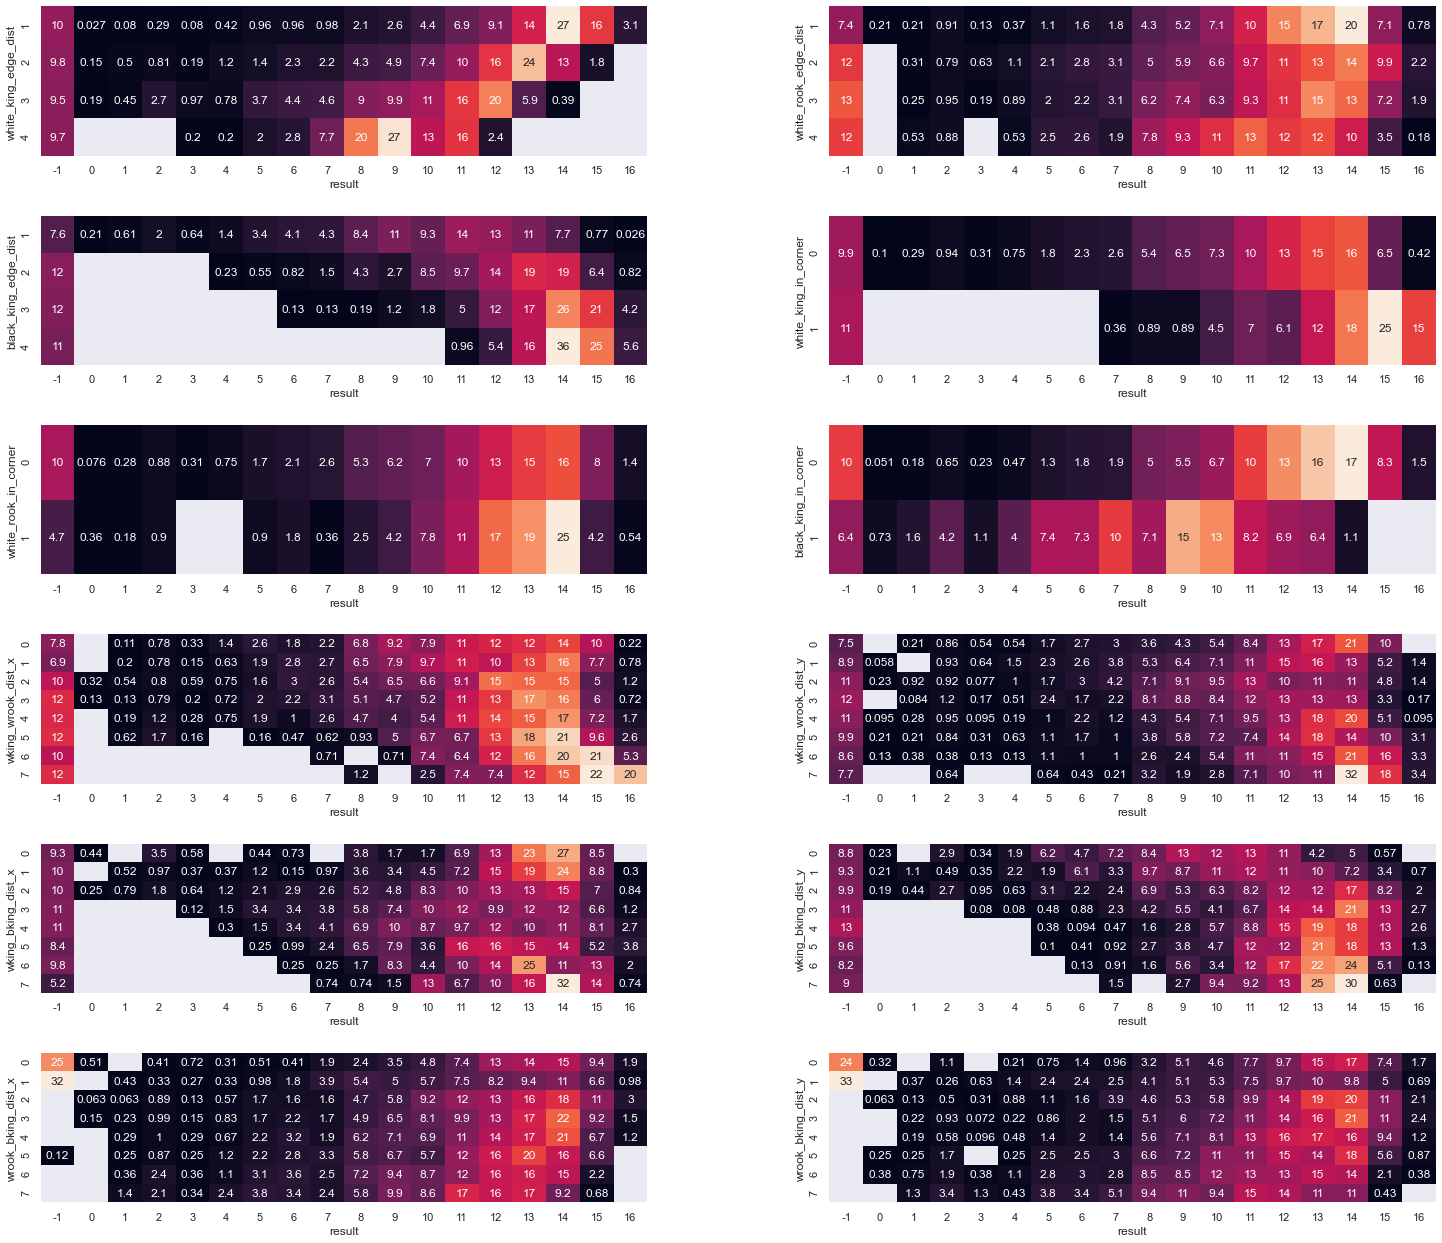

In [51]:
i = 0
fig, axes = plt.subplots(6, 2, figsize = (25, 22))
plt.subplots_adjust(wspace = 0.3, hspace = 0.4)
for col in columns:
    dfprep = df_test_processed.groupby(by = [col]).size().reset_index(name='count_all')
    dfprep2 = df_test_processed.groupby(by = [col, 'result']).size().reset_index(name='count')
    dfprep2 = pd.merge(dfprep, dfprep2, how = "left", on=col)
    dfprep2["percentage"] = dfprep2["count"]/dfprep2["count_all"]*100
    dfprep2 = dfprep2.pivot(col, "result", "percentage")
    sns.heatmap(dfprep2, annot=True, fmt = '.2g',\
                cbar_kws={'orientation': 'horizontal'}, ax = axes[i//2][i%2], cbar = False)
    i += 1
plt.show()

Wnioski dla danych testowych są prawie identyczne jak dla danych treningowych. Wyjątkiem jest odrobinę zwiększone prawdopodobieństwo na remis, jeśli czarny król jest w rogu (o ok. 1,5 punkta procentowego).